# Quantum Teleportation - Basics in Q# #

_I’m very happy to present this article as part of the Q# Advent calendar! Every day, one community member wrote a blog post about or using Q#, the quantum development SDK by Microsoft. Check out the rest of the blog posts at the advent calendar link. And thank you to Microsoft Quantum and team for letting me participate with my post on Quantum teleportation with Q#!_

See the blog post here: https://www.amarchenkova.com/2019/12/25/quantum-teleportation-q-microsoft/

Quantum teleportation is a fundamental concept in quantum computing. It introduces a lot of key quantum computing concepts. Here, I’ll cover what quantum teleportation is, the steps to teleport quantum information, and show you how to write this in Q#, Microsoft’s Quantum Software Development Kit (SDK).

## What is quantum teleportation?


Quantum teleportation is a critical concepts to take advantage of the powers of quantum information. It's the key behind quantum key distribution and long distance quantum communication, and also used in quantum computing. It allows you to "teleport" - or move the quantum state - to another qubit.

But why do we need to do something special to copy quantum information? For classical information, we simply read the bits, and copy them to another place. We can’t do that on a quantum system. The no-cloning theorem says we cannot copy a quantum state exactly. So, we have to do something a little different. Quantum teleportation means we "move" the quantum state of to another qubit. This requires destroying the state of the qubit we teleported, so we do not violate no-cloning.

Quantum teleportation has been successful over 4 miles in Canada and in Hefei over fiber optics, and 870 mi in space at the Quantum Experiments at Space Scale (QUESS) project.

## Steps to quantum teleportation

Quantum teleportation requires 3 qubits, and two classical bits. Alice wants to teleport the state of a qubit to Bob at some distance away.

Along the way, I'll introduce the quantum concepts along with the Q# code.

### Entangle Two of our Qubits

First, Alice has a Qubit (let’s call this the message) Q_message that has some unknown quantum state.

Alice also gets two more qubits. Let's call them Q_Alice and Q_Bob (Q_Alice will remain with her, and she will later send the other qubit to Bob) and entangles them.

Alice entangles these qubits by applying:

In [ ]:
// Entangle pair of qubits
H(Q_Alice);
CNOT(Q_Alice, Q_Bob);

- A Hadamard gate to Q_Alice
- CNOT on Q_Alice and Q_Bob, with Q_Alice being the Control, and Q_Bob being the target

The Hadamard and CNOT sequence is how we entangle a pair of qubits.

The Hadamard gate is a single qubit gate. It puts the qubit into an equal superposition (1/2 probability of 0, 1/2 probability of 1). A Controlled-NOT (CNOT) gate is a two-qubit gate. There is a target qubit, and a control qubit. It performs a NOT on the target qubit only if the control qubit is in the 1 state.

You can now send the entangled qubit (Q_Bob) to Bob.

### Bell measurement

Then, we perform a Bell measurement:

- CNOT gate on Q_message (control) and Q_Alice (target): CNOT(control, target)

- Hadamard on Q_message: H(qubit)

- Measuring Q_message and Q_Alice: M(qubit)

In [ ]:
// Bell measurement
CNOT(Q_message, Q_Alice);
H(Q_message);
let data1 = M(Q_message);
let data2 = M(Q_Alice);

Alice then measures her qubits — we now have a 0 or 1 from each qubit, meaning there are 4 potential combinations: 00, 01, 10, 11.

Alice sends this information to Bob as well. The result of Q_message is the first bit, and the result of Q_Alice the second bit.

### Bob's Operations

After the measurement, depending on what Bob receives, he does an operation on his qubit —

In [ ]:
// Bob's operations
if (data1 == One) { Z(Q_Bob); }
if (data2 == One) { X(Q_Bob); }

If Alice transmits 00: then Bob does nothing to his qubit

If Alice transmits 01: then Bob applies the X gate

If Alice transmits 10: then Bob applies the Z gate

If Alice transmits 11: then Bob applies Z gate, then Bob applies the X gate.

and Bob now has a qubit with the state that Alice's original message qubit had.

#### Congratulations! You have teleported an unknown quantum state using Q#.

_But why does this work?_

This works because the states of Alice's qubit and Bob's qubit depend on each other. Let's look at the full circuit. q[0] is Q_message, q[1] is Q_Alice, and q[2] is Q_Bob.

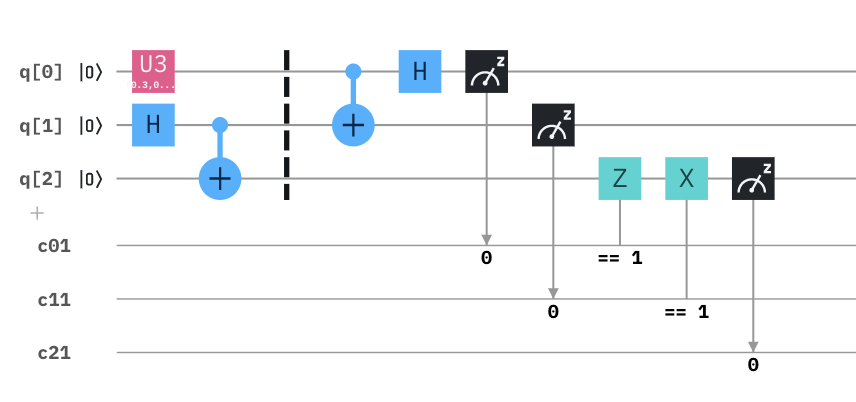


The classical information we receive from Alice tells us how Bob's state differs from Alice's original state, and what gates we need to apply to it to get Bob's qubit back to the initial state.

Then, if Alice sends 00, that means neither of the CNOT gates are activated - that means the state of Bob's doesn't need to change.

If Alice sends 01, that means that the measurement of q[0] was 0, so the CNOT across q[0] and q[1] wasn't activated, since q[0] was the control. However, q[1] was 1. That means the CNOT across q[1] and q[2] is activated, and NOT is applied on q[2], since q[1] was the control and equal to 1. A NOT gate is the equivalent of a X gate. Then, to "undo" that, Bob needs to apply an X gate to his qubit q[2] to get back to the original state of q[0], or the original message qubit.

### Full Code

In [1]:
open Microsoft.Quantum.Intrinsic;
open Microsoft.Quantum.Canon;
open Microsoft.Quantum.Math;
    
    // Set the qubit's state to |+⟩.
    operation SetToPlus(q: Qubit) : Unit {
        Reset(q);
        H(q);
    }

    // Set the qubit's state to |−⟩.
    operation SetToMinus(q: Qubit) : Unit {
        Reset(q);
        X(q);
        H(q);
    }

    // Returns true if qubit is |+> (assumes qubit is either |+> or |->)
    operation IsPlus(q: Qubit) : Bool {
        return (Measure([PauliX], [q]) == Zero);
    }

    // Returns true if qubit is |-> (assumes qubit is either |+> or |->)
    operation IsMinus(q: Qubit) : Bool {
        return (Measure([PauliX], [q]) == One);
    }

    // Prepares the qubit into |+> or |->
    operation PrepareRandomMessage(q: Qubit) : Unit {        
        let choice = RandomInt(2);

        if (choice == 0) {
            Message("Sending |->");
            SetToMinus(q);
        } else {
            Message("Sending |+>");
            SetToPlus(q);
        }
    }

/snippet_.qs(1,90): warning QS6003: The namespace is already open.
/snippet_.qs(2,6): warning QS6003: The namespace is already open.


IsMinus, IsPlus, PrepareRandomMessage, SetToMinus, SetToPlus

In [2]:

/// # Summary
/// Sends the state of one qubit to a target qubit by using
/// teleportation.
/// 
/// Notice that after calling Teleport, the state of `msg` is
/// collapsed.
///
/// # Input
/// ## msg
/// A qubit whose state we wish to send.
/// ## target
/// A qubit initially in the |0〉 state that we want to send
/// the state of msg to.
operation Teleport (msg : Qubit, target : Qubit) : Unit {

    using (register = Qubit()) {
        // Create some entanglement that we can use to send the message.
        
        H(Q_Alice);
        CNOT(Q_Alice, Q_Bob);

        // Encode the message into the entangled pair,
        // and measure the qubits to extract the classical data
        // we need to correctly decode the message into the target qubit:
        CNOT(msg, register);
        H(msg);
        let data1 = M(msg);
        let data2 = M(register);

        // decode the message
        if (data1 == One) { Z(target); }
        if (data2 == One) { X(target); }

        // Reset our "register" qubit before releasing it.
        Reset(register);
    }
}

Teleport

In [3]:
operation TeleportRandomMessage () : Unit {

    using (qubits = Qubit[2]) {
        let msg = qubits[0];
        let target = qubits[1];

        // Prepare |-> or |+> state
        PrepareRandomMessage(msg);

        // Teleport
        Teleport(msg, target);

        // Report message received
        if (IsPlus(target))  { Message("Received |+>"); }
        if (IsMinus(target)) { Message("Received |->"); }

        ResetAll(qubits);
    }
}

TeleportRandomMessage

In [4]:
%simulate TeleportRandomMessage

Sending |+>
Received |+>


()

## Additional Resources: ##

1. https://github.com/microsoft/QuantumKatas/tree/master/Teleportation
2. https://github.com/microsoft/Quantum/tree/master/samples/getting-started/teleportation
3. Hidary, J. D. (2019). Quantum computing: an applied approach. Cham, Switzerland: Springer.
4. Johnston, E. R., Harrigan, N., & Gimeno-Segovia, M. (2019). Programming quantum computers: essential algorithms and code samples. Sabastopal, CA: OReilly Media, Incorporated.